In [1]:
import pandas as pd
import missingno as msno
import numpy as np
import dateutil
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.externals import joblib

Index(['TweetPostedTime', 'TweetID', 'TweetBody', 'TweetRetweetFlag',
       'TweetSource', 'TweetInReplyToStatusID', 'TweetInReplyToUserID',
       'TweetInReplyToScreenName', 'TweetRetweetCount', 'TweetFavoritesCount',
       'TweetHashtags', 'TweetPlaceID', 'TweetPlaceName', 'TweetPlaceFullName',
       'TweetCountry', 'TweetPlaceBoundingBox', 'TweetPlaceAttributes',
       'TweetPlaceContainedWithin', 'UserID', 'UserName', 'UserScreenName',
       'UserLocation', 'UserDescription', 'UserLink', 'UserExpandedLink',
       'UserFollowersCount', 'UserFriendsCount', 'UserListedCount',
       'UserSignupDate', 'UserTweetCount', 'MacroIterationNumber',
       'tweet.place'],
      dtype='object')
            TweetID  TweetInReplyToStatusID  TweetInReplyToUserID  \
count  4.236800e+04            1.010000e+02          1.890000e+02   
mean   8.110767e+17            8.107005e+17          6.489163e+16   
std    4.408380e+13            2.581401e+15          2.140714e+17   
min    8.110045e+17  

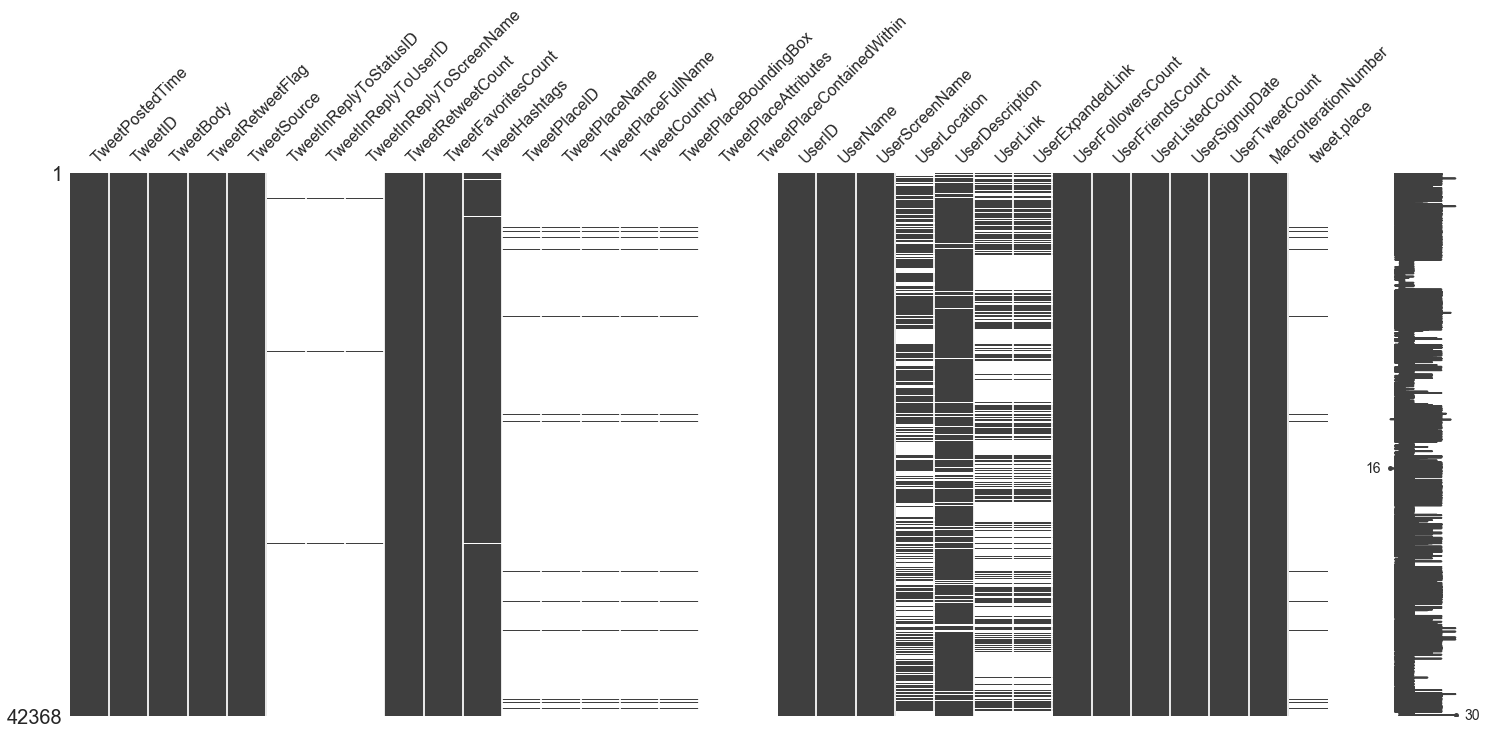

In [4]:
#Read csv and input into pandas dataframe
df = pd.read_csv('J:/Source/Exercises/Exercise3/tweets.csv', error_bad_lines=False, encoding='ISO-8859-1')

#Quick summary of the dataframe
description = df.describe()
columns = df.columns
print(columns)
print(description)
#One row per tweet
#Information about: post date, ID, body, retweet(bool), source, inreplytostatusID, inreplytouserID,
#InreplytoScreenname, number of retweets, number of favourites, hashtags in the tweet, ID of 'place', place name,
#Place full name, country, place bounding box, place attributes, place contained within, userID, user name,
#User screen name, user location, user description, user link, user expanded link, user follower count,
#User friends count, user listed count, user signup date, user tweet count, macro iteration number, place again?

#Analyze missing values:
msno.matrix(df)
#msno.bar(df)

#Significant amount of missing values in:
#TweetInReplyToStatusID, TweetInReplyToUserID, TweetInReplyToScreenName - transform into boolean 'Is the tweet a reply'
#TweetPlaceID, TweetPlaceName, TweetPlaceFullName, TweetCountry, TweetPlaceBoundingBox, tweet.place
    #Limited information about where a tweet was posted from - transform into boolean potential
#TweetPlaceAttributes, TweetPlaceContainedWithin - fully missing, delete?
#Some missing values:
#User Location - fill NaN with 'None', then encode
#User Description - ?
#UserLink, UserExpandedLink - Transform into boolean?

In [5]:
#Create modeling dataframe
dfModel = pd.DataFrame()
dfModel['TweetID'] = df['TweetID']

# Define target as retweet count
dfModel['RetweetCount'] = df['TweetRetweetCount']

# Transform tweet retweet flag from boolean to binary(int)
dfModel['TweetRetweetFlag'] = df['TweetRetweetFlag'].astype(int)

In [6]:
#Define function to check if a cell is null (0) or not(1)
def isCellNull(x):
    if x is np.nan:
        return 0
    return 1
#Transform user inputs (location, description, link) into exists (1) / not exists (0)
dfModel['UserLocation'] = df['UserLocation'].apply(lambda x: isCellNull(x))
dfModel['UserDescription'] = df['UserDescription'].apply(lambda x: isCellNull(x))
dfModel['UserLink'] = df['UserLink'].apply(lambda x: isCellNull(x))

#Create flag for whether tweet is a reply or not
dfModel['TweetIsAReply'] = df['TweetInReplyToStatusID'].apply(lambda x: isCellNull(x))

In [7]:
#Process user signup dates
#Define function to convert UTC into datetime
def convertToDatetime(x):
    converted = dateutil.parser.parse(x)
    return converted
#Convert user singup date and tweet posted time into datetime format
dfModel['UserSignupDate'] = df['UserSignupDate'].apply(lambda x: convertToDatetime(x))
dfModel['TweetPostedTime'] = df['TweetPostedTime'].apply(lambda x: convertToDatetime(x))

#Select the last tweet posting time as a point of reference
latestTweetTime = dfModel['TweetPostedTime'].max()

#Select the hour the tweet was posted at (TO BE ENCODED)
dfModel['TweetTimeslot'] = dfModel['TweetPostedTime'].dt.hour

#Calculate how many days since a user signed up (from reference tweet)
dfModel['DaysSinceSignup'] = (latestTweetTime - dfModel['UserSignupDate']).dt.days

#Calculate how many seconds since a particular tweet (from reference tweet)
dfModel['SecondsSinceTweet'] = (latestTweetTime - dfModel['TweetPostedTime']).dt.seconds

#Count number of favorites on a tweet - scaled to time interval since tweet
dfModel['FavoritesScaledSinceTweet'] = df['TweetFavoritesCount'] / dfModel['SecondsSinceTweet']

#Count number of user tweets - scaled to time interval since user signed up (+1 to avoid inf errors)
dfModel['UserTweetCountScaledSinceCreation'] = df['UserTweetCount'] / (dfModel['DaysSinceSignup'] + 1)

In [8]:
#Separate individual tweet sources by labels (TO BE ENCODED)
def retrieveSource(x):
    indexStart = x.find('>')
    indexEnd = x[indexStart:].find('<')+indexStart
    return x[indexStart+1:indexEnd]
dfModel['TweetSource'] = df['TweetSource'].apply(lambda x: retrieveSource(x))

#Create flag to state whether or not a place is assigned to a tweet
dfModel['TweetPlaceFlag'] = df['TweetPlaceID'].apply(lambda x: isCellNull(x))
#Fill tweet place ID nulls with 'unknown' label (TO BE ENCODED)
dfModel['TweetPlaceID'] = df['TweetPlaceID'].fillna('Unknown')

#Encode categorical labels
dfModel = pd.get_dummies(dfModel, prefix=['TweetSource', 'TweetPlaceID'],
                           columns=['TweetSource', 'TweetPlaceID'])

In [9]:
#Process Hashtags
#Fill empty hashtags with label
df['TweetHashtags'].fillna('NoHashtag', inplace=True)
#Define count vectorizer for hashtag counts
cntv = CountVectorizer(lowercase=True, analyzer='word', ngram_range=(1,1), binary=True)
hashtagMatrix = cntv.fit_transform(df['TweetHashtags'])
hashtagMatrix = pd.DataFrame(hashtagMatrix.toarray())
hashtagMatrix = hashtagMatrix.add_prefix('hashtag')
dfModel = pd.merge(dfModel, hashtagMatrix, left_index=True, right_index=True)

In [10]:
#Release memory
del cntv
del columns
del description
del latestTweetTime
del hashtagMatrix

In [11]:
'''
#Process tweet text - procedure only illustrated for concept
tweetBody = df['TweetBody']
del df
#Procedure not used due to memory errors on current environment
#Define tokenizer function -- not used in this case as not words are in english (corpora not available on machine)
def tokenizer_porter(text):
    porter = PorterStemmer()
    return [porter.stem(word) for word in text.split()]
#Define stop words -- not used in this case as not all tweets are in english
stop = stopwords.words('english')
#Define term frequency inverse document frequency
tfidf = TfidfVectorizer(strip_accents=None, ngram_range=(1,1), stop_words=None, tokenizer=None)
tweetMatrix = tfidf.fit_transform(tweetBody)
tweetMatrix = pd.DataFrame(tweetMatrix.toarray())
tweetMatrix = tweetMatrix.add_prefix('body')
dfModel = pd.merge(dfModel, tweetMatrix, left_index=True, right_index=True)
del tweetMatrix
joblib.dump(dfModel, 'modelData.pkl')
'''

"\n#Process tweet text - procedure only illustrated for concept\ntweetBody = df['TweetBody']\ndel df\n#Procedure not used due to memory errors on current environment\n#Define tokenizer function -- not used in this case as not words are in english (corpora not available on machine)\ndef tokenizer_porter(text):\n    porter = PorterStemmer()\n    return [porter.stem(word) for word in text.split()]\n#Define stop words -- not used in this case as not all tweets are in english\nstop = stopwords.words('english')\n#Define term frequency inverse document frequency\ntfidf = TfidfVectorizer(strip_accents=None, ngram_range=(1,1), stop_words=None, tokenizer=None)\ntweetMatrix = tfidf.fit_transform(tweetBody)\ntweetMatrix = pd.DataFrame(tweetMatrix.toarray())\ntweetMatrix = tweetMatrix.add_prefix('body')\ndfModel = pd.merge(dfModel, tweetMatrix, left_index=True, right_index=True)\ndel tweetMatrix\njoblib.dump(dfModel, 'modelData.pkl')\n"

In [12]:
#Cleanup model dataframe
del dfModel['UserSignupDate']
del dfModel['TweetPostedTime']
dfModel.fillna(0, inplace=True)

In [ ]:
#Dump pickle file with modeling-ready dataset
joblib.dump(dfModel, 'modelDataset.pkl')